# SelectQAOA: Regression Test Case Selection Using QAOA
Regression testing is an important part of the software development process in software engineering. It is a practice aimed at identifying any regression, which are the emergence of new defects or issues in a software application following changes, enhancements, or updates made to the source code. In other words, regression testing focuses on how changes made to the software can affect the correct behavior of existing features. Regression testing is particularly important in agile software development environments, where changes are made frequently and rapidly. This practice helps ensure that the software remains stable and reliable as it evolves over time. Ideal regression testing would re-run all the available test cases of a given software system. However, in addition to being potentially very costly, this could even be impractical in some case. In this scenario, test case selection is one of the most widely investigated test suite optimization approaches.
Test case selection focuses on selecting a subset from an initial test suite to test software changes, i.e., to test whether unmodified parts of a program continue to work correctly after changes involving other parts. Various techniques, such as Integer Programming, symbolic execution, data flow analysis, dependence graph-based methods, and flow graph-based approaches, can be employed to identify the modified portions of the software. Once test cases covering the unchanged program segments are pinpointed using a specific technique, an optimization algorithm (e.g., additional greedy, DIV-GA,
SelectQA, BootQA or SelectQAOA) can select a minimal set of these test cases based on certain testing criteria (e.g., branch coverage). The ultimate aim is to reduce the expenses associated with regression testing.

In [19]:
#this cell contains all the imports needed by the pipeline
#to run it on the browser: jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
import os
import json
import time

import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import statistics
import csv

from qiskit import transpile
from scipy.stats import mannwhitneyu, shapiro
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import BackendSampler
from qiskit_algorithms import QAOA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer import Aer, AerSimulator
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, depolarizing_error
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster
from collections import defaultdict
from scipy.spatial.distance import cdist

In [2]:
#this is the constant that represent the number of experiments' iterations
tot_run = 10

## The pipeline dataset
To experiment the performance of the proposed solution by this work and to compare its results to those of state-of-the-art solutions, 4 public programs have been downloaded from the SIR website. SIR is a repository of software-related artifacts meant to support rigorous controlled experimentation with program analysis and software testing techniques, and education in controlled experimentation. 

### Chosen SIR Programs
The programs that will be used for experimentation have all been written in C and are:
- flex (a program that generates a lexical analysis program, based on regular expressions and C statement contained in one or more input files);
- grep (a useful program to search form matching patterns in a file);
- gzip (a program that substitute a file, generally text files or web pages, with their compressed version)
- sed (a powerful program for stream text editing).

### Needed information
The information needed by the quantum algorithm to work on every one of the 4 programs are:
- a fault matrix: it indicates whether a precise test case already found, during previous execution, a bug in the source code or not;
- execution cost: it indicates the execution cost of any test case of the suite;
- statement coverage: it indicates statement coverage information for every test case. 

All this information have been gathered through previous experimentation on the four programs mentioned above and written in files organized in the SIR_Programs folder. So, the first goal of the project will be gathering data from these files for computational purposes.

In [3]:
#this cell contains all variable definitions that will be useful throughout the entire project
sir_programs = ["gzip"]
sir_programs_tests_number = {"flex":567,"grep":806,"gzip":214,"sed":360}
sir_programs_end_lines = {"flex":14192,"grep":13281,"gzip":6701,"sed":7118}
alpha = 0.5

In [4]:
#let's make a function to read the fault matrices
#IMPORTANT: all the fault-matrix files must be renamed as "fault-matrix".txt and must be written using the same standard used by the files of this project (i-th line->e0e1e2e3..., where ej is 0 if the i-th test found a bug when launched on the j-th version)
def get_fault_list(program_name:str):
    """This function opens the fault-matrix file of a sir programs and makes a list of binary values for each test case of that program to indicate whether a test case found or not a bug in at least one of the available versions of the program"""
    #open the fault-matrix file of the desired SIR program
    program_file = open("datasets/sir_programs/"+program_name+"/fault-matrix.txt")
    lines = program_file.readlines()
    
    #we need a list which elements represent test cases, the i-th element is 1 if the i-th test case
    #discovered a fault in the past, 0 otherwise
    faults_test_by_test = list()
    
    i = 0
    for line in lines:
        if "1" in line:
            faults_test_by_test.append(1)
        else:
            faults_test_by_test.append(0)
        i += 1
    
    program_file.close()
    
    return faults_test_by_test

In [5]:
#the next function is able to research into the json coverage information file of each test case
#of each sir program to gather information about the single test cases costs and coverage
def cost_and_coverage_information_gathering(program_name:str):
    """The aim of this function is to obtain a dictionary that for each test case of a program indicates its cost, and a dictionary that, for each code line of the program to test, makes a list of all the test cases that run that line"""
    test_case_execution_cost = 0
    
    execution_cost_test_by_test = dict()
    executed_lines_test_by_test = dict()
    lines_of_tests_list = dict()
    total_file_lines = 0
    read_files = []
    
    for test_case in range(sir_programs_tests_number[program_name]):
        #to open the correct file, we must remember that the folders and the json files are
        #numbered from 1 and not from 0
        if program_name == "gzip":
            json_name = "allfile"
        else:
            json_name = program_name
        test_case_json = open("datasets/sir_programs/"+program_name+"/json_"+program_name+"/t"+str(test_case+1)+"/"+json_name+str(test_case+1)+".gcov.json")
        
        #read the JSON object as a dictionary
        json_data = json.load(test_case_json)
        
        # to have coverage % we will need the total number of lines to cover
        for file in json_data["files"]:
            if file["file"] not in read_files:
                total_file_lines += len(file["lines"])
                read_files.append(file["file"])
        
        #for programs tested above more than one file, the initial row of a file will start from
        #the final row of the preceding file
        i = 0
        for file in json_data["files"]:
            line_count_start = i
            for line in file["lines"]:
                #if a line is executed, we want to remember FOR THAT LINE which are the tests
                #that executed it, and we want to increment the execution cost
                if line["unexecuted_block"] == False:
                    #the test suite exec cost = sum of the exec freq. of each executed basic block
                    #by each test case
                    #test_suite_execution_cost += line["count"]
                    test_case_execution_cost += line["count"]
                    
                    if (line_count_start + line["line_number"]) not in executed_lines_test_by_test:
                        executed_lines_test_by_test[line_count_start + line["line_number"]] = [test_case]
                    else:
                        executed_lines_test_by_test[line_count_start + line["line_number"]].append(test_case)
                    executed_lines_test_by_test[line_count_start + line["line_number"]].sort()
                    
                    if test_case not in lines_of_tests_list:
                        lines_of_tests_list[test_case] = [line_count_start + line["line_number"]]
                    else:
                        lines_of_tests_list[test_case].append(line_count_start + line["line_number"])
                    lines_of_tests_list[test_case].sort()
                i = line["line_number"]
        
        #saving the total amount of execution cost for this test case and resetting for the next
        execution_cost_test_by_test[test_case] = test_case_execution_cost
        test_case_execution_cost = 0
        
        test_case_json.close()
                        
    return execution_cost_test_by_test, executed_lines_test_by_test, lines_of_tests_list, total_file_lines
                    

In [6]:
#we can now gain all the historical information about past fault detection 
faults_dictionary = {"flex": None, "grep": None, "gzip": None, "sed": None}

for sir_program in sir_programs:
    faults_dictionary[sir_program] = (get_fault_list(sir_program))
    
print(faults_dictionary)
#print(len(faults_dictionary["grep"]))

{'flex': None, 'grep': None, 'gzip': [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], 'sed': None}


In [7]:
#we can now gain costs and coverage information

test_cases_costs = {"flex":None,"grep":None,"gzip":None,"sed":None}
coverage = {"flex":None,"grep":None,"gzip":None,"sed":None}
lines_of_tests_list = {"flex":None,"grep":None,"gzip":None,"sed":None}
total_file_lines = {"flex":None,"grep":None,"gzip":None,"sed":None}

for sir_program in sir_programs:
    costs_and_coverage = cost_and_coverage_information_gathering(sir_program)
    test_cases_costs[sir_program] = costs_and_coverage[0]
    coverage[sir_program] = costs_and_coverage[1]
    lines_of_tests_list[sir_program] = costs_and_coverage[2]
    total_file_lines[sir_program] = costs_and_coverage[3]

print(test_cases_costs)

{'flex': None, 'grep': None, 'gzip': {0: 62, 1: 62, 2: 46, 3: 46, 4: 56, 5: 56, 6: 1872175, 7: 1872145, 8: 164776, 9: 115, 10: 164776, 11: 164776, 12: 66, 13: 1872143, 14: 68, 15: 1872147, 16: 160, 17: 160, 18: 160, 19: 164768, 20: 164849, 21: 164768, 22: 66, 23: 1872180, 24: 67, 25: 739130, 26: 67, 27: 67, 28: 67, 29: 67, 30: 67, 31: 67, 32: 67, 33: 67, 34: 3043101, 35: 12051, 36: 16113, 37: 0, 38: 164791, 39: 344660, 40: 164774, 41: 0, 42: 0, 43: 278591, 44: 1872140, 45: 1872140, 46: 60795506, 47: 164776, 48: 22632, 49: 274103, 50: 108, 51: 60, 52: 3572807, 53: 344181, 54: 61, 55: 739183, 56: 787328, 57: 950835, 58: 1019739, 59: 1423536, 60: 1872199, 61: 2148479, 62: 2942506, 63: 3043154, 64: 1872193, 65: 739145, 66: 787290, 67: 950797, 68: 1019701, 69: 1423498, 70: 1872161, 71: 2148441, 72: 2942468, 73: 3043116, 74: 1872155, 75: 739178, 76: 787323, 77: 950830, 78: 1019734, 79: 1423531, 80: 1872194, 81: 2148474, 82: 2942501, 83: 3043149, 84: 1872188, 85: 739140, 86: 787285, 87: 95079

In [8]:
#print(lines_of_tests_list)
for sir_program in sir_programs:
    for i in range(sir_programs_tests_number[sir_program]):
        if i not in lines_of_tests_list[sir_program].keys():
            lines_of_tests_list[sir_program][i] = []
print(lines_of_tests_list)

{'flex': None, 'grep': None, 'gzip': {0: [4399, 4404, 4415, 4522, 4530, 4531, 4533, 4534, 5162, 5164, 5177, 5180, 5217, 5219, 5220, 5221, 5222, 5289, 5299, 5300, 5303, 5304, 5308, 5311, 5312, 5313, 5316, 5317, 5321, 5322, 5334, 5335, 5337, 5338, 5343, 5344, 5346, 5347, 5348, 5360, 5361, 6669, 6675, 6688], 1: [4399, 4404, 4415, 4522, 4530, 4531, 4533, 4534, 5162, 5164, 5177, 5180, 5217, 5219, 5220, 5221, 5222, 5289, 5299, 5300, 5303, 5304, 5308, 5311, 5312, 5313, 5316, 5317, 5321, 5322, 5334, 5335, 5337, 5338, 5343, 5344, 5346, 5347, 5348, 5360, 5361, 6669, 6675, 6688], 2: [4399, 4404, 4415, 4522, 4530, 4531, 4533, 4534, 5225, 5227, 5229, 5230, 5231, 5289, 5299, 5300, 5303, 5304, 5308, 5311, 5312, 5313, 5316, 5317, 5321, 5322, 5334, 5335, 5337, 5338, 5343, 5344, 5346, 5347, 5348, 5364, 5365, 6669, 6675, 6688], 3: [4399, 4404, 4415, 4522, 4530, 4531, 4533, 4534, 5225, 5227, 5229, 5230, 5231, 5289, 5299, 5300, 5303, 5304, 5308, 5311, 5312, 5313, 5316, 5317, 5321, 5322, 5334, 5335, 5337, 5

In [9]:
print(total_file_lines)

{'flex': None, 'grep': None, 'gzip': 2034, 'sed': None}


In [10]:
print(coverage)

{'flex': None, 'grep': None, 'gzip': {4399: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213], 4404: 

In [11]:
len(coverage["gzip"].keys())/total_file_lines["gzip"]

0.5580137659783677

## Quantum Approximate Optimization Algorithm (QAOA)
The Quantum Approximate Optimization Algorithm (QAOA) is a quantum algorithm designed to tackle combinatorial optimization problems by combining classical and quantum computing techniques. It encodes the optimization problem into a Quantum Unconstrained Binary Optimization (QUBO) format and constructs a parameterized quantum circuit that alternates between applying the problem Hamiltonian, which represents the optimization goal, and a mixing Hamiltonian, which promotes exploration of the solution space. The parameters of this circuit are optimized using classical optimization methods to maximize the likelihood of measuring the optimal solution. Once the parameters are tuned, the circuit is executed on a quantum device or simulator to obtain candidate solutions, making QAOA particularly suitable for NP-hard problems like graph partitioning and maximum cut. This hybrid approach highlights the potential of quantum computing to provide advantages in solving complex optimization challenges.

## QUBO Problems
A Quadratic Unconstrained Binary Optimization (QUBO) problem is a type of mathematical problem where we seek to find the best combination of binary values (0 or 1) for a set of variables to minimize or maximize an objective function. In other words, we are looking for the optimal solution among all possible variable combinations that satisfies certain constraints and makes the objective function as small as possible.

Weights for constraints (or penalty coefficients) are used in QUBO problems to assign a numerical value to the constraints and influence the optimization process. These weights are important because they allow for managing the priority and relative importance of constraints within the optimization problem.

Single test cases coverage: [44, 44, 40, 40, 50, 50, 487, 466, 351, 82, 351, 351, 63, 465, 65, 468, 106, 106, 106, 347, 393, 347, 63, 492, 64, 458, 64, 64, 64, 64, 64, 64, 64, 64, 469, 161, 305, 359, 400, 357, 157, 463, 463, 491, 351, 405, 181, 98, 59, 477, 353, 60, 491, 488, 495, 499, 500, 500, 500, 501, 502, 497, 465, 462, 469, 473, 474, 474, 474, 475, 476, 471, 489, 486, 493, 497, 498, 498, 498, 499, 500, 495, 463, 460, 467, 471, 472, 472, 472, 473, 474, 469, 489, 486, 493, 497, 498, 498, 498, 499, 500, 495, 461, 458, 465, 469, 470, 470, 470, 471, 472, 467, 487, 484, 491, 495, 496, 496, 496, 497, 498, 493, 459, 456, 463, 467, 468, 468, 468, 469, 470, 465, 490, 487, 494, 498, 499, 499, 499, 500, 501, 496, 464, 461, 468, 472, 473, 473, 473, 474, 475, 470, 488, 485, 492, 496, 497, 497, 497, 498, 499, 494, 462, 459, 466, 470, 471, 471, 471, 472, 473, 468, 488, 485, 492, 496, 497, 497, 497, 498, 499, 494, 460, 457, 464, 468, 469, 469, 469, 470, 471, 466, 486, 483, 490, 494, 495, 495, 495

/var/folders/kn/kd67nwcs41113fgwjn39d7fm0000gn/T/ipykernel_1603/3428449709.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_clusters)  # A colormap with as many colors as clusters


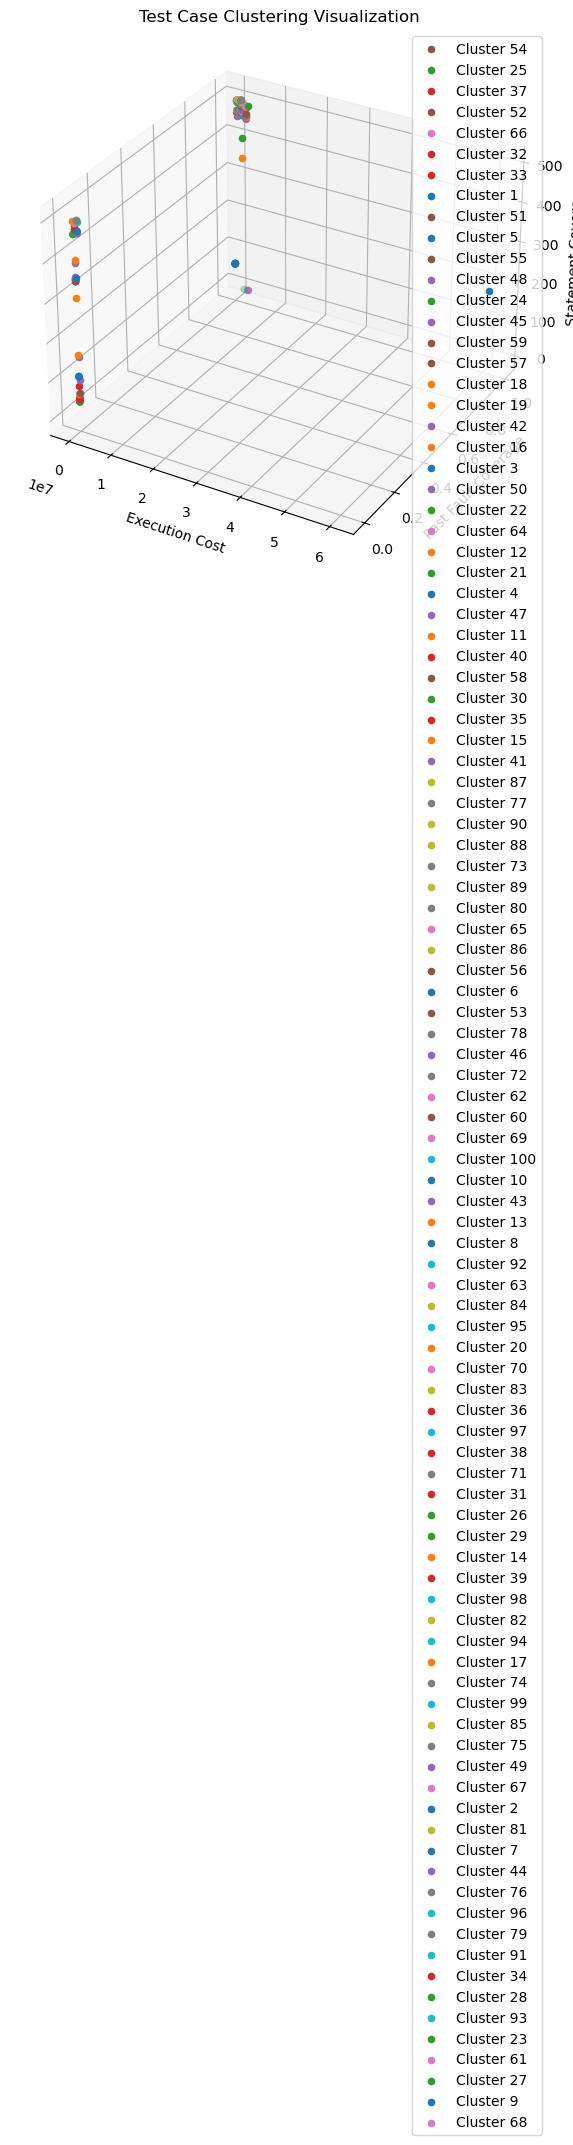

{'gzip': defaultdict(<class 'list'>, {53: [0, 1], 24: [2, 3], 36: [4, 5], 51: [6], 65: [7, 13, 104, 164], 31: [8, 10, 11], 32: [9], 0: [12, 14, 22, 24, 26], 50: [15, 64, 84, 144, 210], 4: [16, 17, 18], 54: [19, 21], 47: [20], 23: [23, 74, 94, 154, 174], 44: [25], 58: [27], 56: [34], 17: [35], 18: [36], 41: [37], 15: [38], 2: [39], 49: [40], 21: [41, 42], 63: [43], 11: [44], 20: [45], 3: [46], 46: [47], 10: [48, 51], 39: [49], 57: [50], 29: [52], 34: [53], 14: [54], 40: [55, 76, 96, 136], 86: [56], 76: [57, 137], 89: [58, 138], 87: [59], 72: [60, 80, 100, 140], 88: [61], 79: [62], 64: [63], 85: [65, 145], 55: [66], 5: [67, 87, 147], 52: [68], 77: [69, 149], 45: [70], 71: [71, 91, 151], 61: [72, 92, 132, 152], 59: [73, 93, 133, 153], 68: [75, 95, 135, 155, 175], 99: [77, 97], 9: [78, 98, 158, 178], 42: [79, 99, 139], 12: [81, 101, 141], 7: [82, 142, 162], 91: [83, 143], 62: [85, 165], 83: [86, 146], 94: [88, 148], 19: [89, 109, 169], 69: [90, 150, 170], 82: [102, 182], 35: [103, 163, 183

In [12]:
def total_coverage(sir_program,test_cases):
    covered_lines = set()
    
    for test_case in test_cases:
        try:
            for covered_line in lines_of_tests_list[sir_program][test_case]:
                covered_lines.add(covered_line)
        except:
            continue
    
    return len(covered_lines)

clusters_dictionary = dict()

for sir_program in sir_programs:
    tot_test_cases = sir_programs_tests_number[sir_program]
    
    # from {..., test_case_i : [cov_stmts], ...} to [..., #_stmt_cov_i, ...]
    test_cases_stmt_cov = []
    for test_case in lines_of_tests_list[sir_program].keys():
        test_cases_stmt_cov.append(len(lines_of_tests_list[sir_program][test_case]))
    suite_stmt_cov = sum(test_cases_stmt_cov)
    print("Single test cases coverage: " + str(test_cases_stmt_cov))
    print("Suite stmt coverage: " + str(suite_stmt_cov))
    
    # Normalize data
    data = np.column_stack((list(test_cases_costs[sir_program].values()),faults_dictionary[sir_program],test_cases_stmt_cov))
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)

    num_clusters = 100
    
    # Step 2: Perform K-Means Clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=43)
    clusters = kmeans.fit_predict(normalized_data)
    
    # Organize test cases by cluster
    clustered_data = defaultdict(list)
    for idx, cluster_id in enumerate(clusters):
        clustered_data[cluster_id].append(idx)
        
    # Step 4: Reassign points to ensure each cluster has at most 30 elements
    max_elements_per_cluster = 5
    for cluster_id, points in list(clustered_data.items()):
        if len(points) > max_elements_per_cluster:
            excess_points = points[max_elements_per_cluster:]
            clustered_data[cluster_id] = points[:max_elements_per_cluster]
            
            # Reassign excess points
            excess_data = normalized_data[excess_points]
            remaining_clusters = [k for k in clustered_data if len(clustered_data[k]) < max_elements_per_cluster]
            
            # Find nearest cluster with space for each excess point
            distances = cdist(excess_data, kmeans.cluster_centers_[remaining_clusters])
            nearest_clusters = np.argmin(distances, axis=1)
            
            for i, excess_idx in enumerate(excess_points):
                new_cluster = remaining_clusters[nearest_clusters[i]]
                clustered_data[new_cluster].append(excess_idx)
    
    clusters_dictionary[sir_program] = clustered_data
        
    # Step 3: Calculate the metrics for each cluster and validate
    cluster_metrics = {}
    for cluster_id in clustered_data.keys():
        tot_cluster_exec_cost = 0
        tot_cluster_past_fault_cov = 0
        tot_cluster_stmt_cov = 0
        for test_case in clustered_data[cluster_id]:
            tot_cluster_exec_cost += test_cases_costs[sir_program][test_case]
            tot_cluster_past_fault_cov += faults_dictionary[sir_program][test_case]
        tot_cluster_past_fault_cov = tot_cluster_past_fault_cov/tot_test_cases
        tot_cluster_stmt_cov = total_coverage(sir_program,clustered_data[cluster_id])/total_file_lines[sir_program]
        cluster_metrics[cluster_id] = {
            "tot_exec_cost": tot_cluster_exec_cost,
            "tot_past_fault_cov": tot_cluster_past_fault_cov,
            "tot_stmt_cov": tot_cluster_stmt_cov  # Avg stmt coverage per test case in cluster
        }
        print(f"Cluster {cluster_id + 1} metrics:")
        print(f"Test Cases: {clustered_data[cluster_id]}")
        print(f" - Num. Test Cases: {len(clustered_data[cluster_id]):.2f}")
        print(f" - Execution Cost: {tot_cluster_exec_cost:.2f}")
        print(f" - Past Fault Coverage (%): {tot_cluster_past_fault_cov}")
        print(f" - Statement Coverage (%): {tot_cluster_stmt_cov:.2f}\n")
    
    for cluster_id in clustered_data.keys():
        print("Test cases of cluster " + str(cluster_id) + ": " + str(len(clustered_data[cluster_id])))
    
    # Plotting the clusters in 3D space
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extracting data for plotting
    exec_costs = np.array(list(test_cases_costs[sir_program].values()))
    fault_covs = np.array(faults_dictionary[sir_program])
    stmt_covs = np.array(test_cases_stmt_cov)
    
    # Plot each cluster with a different color
    colors = plt.cm.get_cmap("tab10", num_clusters)  # A colormap with as many colors as clusters
    for cluster_id in clustered_data.keys():
        cluster_indices = clustered_data[cluster_id]
        
        # Plot each cluster's points
        ax.scatter(
            exec_costs[cluster_indices], 
            fault_covs[cluster_indices], 
            stmt_covs[cluster_indices], 
            color=colors(cluster_id), 
            label=f"Cluster {cluster_id + 1}"
        )
    
    # Label the axes
    ax.set_xlabel("Execution Cost")
    ax.set_ylabel("Past Fault Coverage")
    ax.set_zlabel("Statement Coverage")
    ax.legend()
    ax.set_title("Test Case Clustering Visualization")
    
    # Display the plot
    plt.show()
    
print(clusters_dictionary)

In [13]:
def make_linear_terms(sir_program, cluster_test_cases, alpha):
    max_cost = max(test_cases_costs[sir_program].values())
    
    estimated_costs = []

    #linear coefficients, that are the diagonal of the matrix encoding the QUBO
    for test_case in cluster_test_cases:
        estimated_costs.append((alpha * (test_cases_costs[sir_program][test_case]/max_cost)) - (1 - alpha) * faults_dictionary[sir_program][test_case])
    
    return np.array(estimated_costs)

def make_quadratic_terms(sir_program, variables, cluster_test_cases, linear_terms, penalty):
    quadratic_terms = {}
    
    #k is a stmt
    for k in coverage[sir_program].keys():
        #k_test_cases is the list of test cases covering k
        k_test_cases = coverage[sir_program][k]
        for i in k_test_cases:
            if i not in cluster_test_cases or i not in variables:
                continue
            for j in k_test_cases:
                if j not in cluster_test_cases or j not in variables:
                    continue
                if i < j:
                    linear_terms[variables.index(i)] -= penalty
                    try:
                        quadratic_terms[variables.index(i),variables.index(j)] += 2 * penalty
                    except:
                        quadratic_terms[variables.index(i),variables.index(j)] = 2 * penalty
    
    return quadratic_terms

In [14]:
def create_QUBO_problem(linear_terms, quadratic_terms):
    """This function is the one that has to encode the QUBO problem that QAOA will have to solve. The QUBO problem specifies the optimization to solve and a quadratic binary unconstrained problem"""
    qubo = QuadraticProgram()
    
    for i in range(0,len(linear_terms)):
        qubo.binary_var('x%s' % (i))

    qubo.minimize(linear=linear_terms,quadratic=quadratic_terms)

    return qubo


In [15]:
penalties_dictionary = {"flex":None,"grep":None,"gzip":None,"sed":None}

#to obtain a QUBO problem from a quadratic problem with constraints, we have to insert those constraints into the Hamiltonian to solve (which is the one encoded by the QUBO problem). When we insert constraint into the Hamiltonian, we have to specify also penalties
for sir_program in sir_programs:
    max_penalty = 0
    max_cost = max(test_cases_costs[sir_program].values())
    for i in range(sir_programs_tests_number[sir_program]):
        cost = (alpha * (test_cases_costs[sir_program][i]/max_cost)) - ((1 - alpha) * faults_dictionary[sir_program][i])
        if cost > max_penalty:
            max_penalty = cost
    penalties_dictionary[sir_program] = max_penalty + 1

In [16]:
qubos_dictionary = {"flex":[],"grep":[],"gzip":[],"sed":[]}
#make a dictionary that saves, for each program, the correspondent QUBO
for sir_program in sir_programs:
    print("SIR Program:\n")
    for cluster_id in clusters_dictionary[sir_program]:
        print("Cluster ID: " + str(cluster_id))
        variables = []
        for idx in range(0, len(clusters_dictionary[sir_program][cluster_id])):
            variables.append(idx)
        linear_terms = make_linear_terms(sir_program, clusters_dictionary[sir_program][cluster_id], alpha)
        quadratic_terms = make_quadratic_terms(sir_program, variables, clusters_dictionary[sir_program][cluster_id], linear_terms, penalties_dictionary[sir_program])
        qubo = create_QUBO_problem(linear_terms, quadratic_terms)
        qubos_dictionary[sir_program].append(qubo)
        print(qubo)
        print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
    print("======================================================================================")

SIR Program:

Cluster ID: 53
minimize 88.68815514094086*x0*x1 - 44.344077060564324*x0 + 5.099061104944172e-07*x1 (2 variables, 0 constraints, '')
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Cluster ID: 24
minimize 3.783174368184385e-07*x0 + 3.783174368184385e-07*x1 (2 variables, 0 constraints, '')
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Cluster ID: 36
minimize 4.6056035786592513e-07*x0 + 4.6056035786592513e-07*x1 (2 variables, 0 constraints, '')
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Cluster ID: 51
minimize -0.4846026859287922*x0 (1 variables, 0 constraints, '')
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Cluster ID: 65
minimize -0.48460293265755533*x0 - 0.48460294910613955*x1 - 0.4846025790129948*x2 - 0.4846026036858711*x3 (4 variables, 0 constraints, '')
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Cluster ID: 31
minimize 0.0013551659558520659*x0 + 0.0013551659558520659*x1 + 0.0013551659558520659*x2 (3 variables, 0 constr

In [17]:
def get_stmt_coverage(sir_program,test_cases_list):
    covered_lines = set()
    
    for test_case in test_cases_list:
        try:
            for covered_line in lines_of_tests_list[sir_program][test_case]:
                covered_lines.add(covered_line)
        except:
            continue
    
    return len(covered_lines)

def build_pareto_front(sir_program,selected_tests):
    pareto_front = []
    max_fault_coverage = 0
    max_stmt_coverage = 0
    
    for index in range(1,len(selected_tests)+1):
        #exract the first index selected tests
        candidate_solution = selected_tests[:index]
        candidate_solution_fault_coverage = 0
        candidate_solution_stmt_coverage = 0
        for selected_test in candidate_solution:
            candidate_solution_fault_coverage += faults_dictionary[sir_program][selected_test]
            candidate_solution_stmt_coverage += get_stmt_coverage(sir_program,candidate_solution)
        #if the actual pareto front dominates the candidate solution, get to the next candidate
        if max_fault_coverage >= candidate_solution_fault_coverage and max_stmt_coverage >= candidate_solution_stmt_coverage:
            continue
        #eventually update the pareto front information
        if candidate_solution_stmt_coverage > max_stmt_coverage:
            max_stmt_coverage = candidate_solution_stmt_coverage
        if candidate_solution_fault_coverage > max_fault_coverage:
            max_fault_coverage = candidate_solution_fault_coverage
        #add the candidate solution to the pareto front
        pareto_front.append(candidate_solution)
    
    return pareto_front

## Statevector Simulator

In [20]:
algorithm_globals.random_seed = 10598
backend = Aer.get_backend("statevector_simulator")
qaoa_mes = QAOA(sampler=BackendSampler(backend=backend), optimizer=COBYLA(), reps=1)
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA

#I want to run the sampler 30 times to obtain different results for each sir program
for sir_program in sir_programs:
    #the fronts will be saved into files
    print(sir_program)
    file_path = "results/selectqaoa/statevector_sim/" + sir_program + "-data.json"
    json_data = {}
    response = None
    qpu_run_times = []
    pareto_fronts_building_times = []
    for i in range(10):
        final_selected_tests = []
        cluster_dict_index = 0
        for qubo in qubos_dictionary[sir_program]:
            print("Experiment Number: " + str(i))
            print("QUBO Problem: " + str(qubo) + "\nNumber: " + str(cluster_dict_index))
            print("Cluster's Test Cases: " +str(list(clusters_dictionary[sir_program].values())[cluster_dict_index]))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.solve(qubo)
            print("RESULTS: " + str(qaoa_result))
            e = time.time()
            qpu_run_times.append((e - s) * 1000)
            #let's extract the selected tests
            variable_values = qaoa_result.x
            indexes_selected_tests = [index for index, value in enumerate(variable_values) if value == 1]
            print("Indexes of selected tests to convert. " + str(indexes_selected_tests))
            selected_tests = []
            for index in indexes_selected_tests:
                selected_tests.append(list(clusters_dictionary[sir_program].values())[cluster_dict_index][index])
            print("Selected tests: " + str(selected_tests))
            cluster_dict_index += 1
            for selected_test in selected_tests:
                if selected_test not in final_selected_tests:
                    final_selected_tests.append(selected_test)
        i+=1
        #now we have to build the pareto front
        print("Final Selected Test Cases: " + str(final_selected_tests))
        print(len(final_selected_tests))
        start = time.time()
        pareto_front = build_pareto_front(sir_program, final_selected_tests)
        end = time.time()
        json_data["pareto_front_" + str(i)] = pareto_front
        pareto_front_building_time = (end - start) * 1000
        pareto_fronts_building_times.append(pareto_front_building_time)

    #compute the average time needed for the construction of a pareto frontier and run time
    mean_qpu_run_time = statistics.mean(qpu_run_times)
    mean_pareto_fronts_building_time = statistics.mean(pareto_fronts_building_times)
    json_data["mean_qpu_run_time(ms)"] = mean_qpu_run_time
    json_data["mean_pareto_fronts_building_time(ms)"] = mean_pareto_fronts_building_time

    with open(file_path, "w") as file:
        json.dump(json_data, file)


/var/folders/kn/kd67nwcs41113fgwjn39d7fm0000gn/T/ipykernel_6237/1932481063.py:3: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  qaoa_mes = QAOA(sampler=BackendSampler(backend=backend), optimizer=COBYLA(), reps=1)


sed
Experiment Number: 0
QUBO Problem: minimize 234.21444429635028*x0*x1 + 224.24787219863322*x0*x4 + 224.24787219863322*x1*x4 - 229.73096022391965*x0 - 112.62373807574419*x1 - 0.49981149679163733*x2 - 0.49981149679163733*x3 - 0.49981149679163733*x4 (5 variables, 0 constraints, '')
Number: 0
Cluster's Test Cases: [0, 1, 4, 10, 11]
RESULTS: fval=-0.9996229935832747, x0=0.0, x1=0.0, x2=1.0, x3=1.0, x4=0.0, status=SUCCESS
Indexes of selected tests to convert. [2, 3]
Selected tests: [4, 10]
Experiment Number: 0
QUBO Problem: minimize 102.15736400159935*x2*x3 + 0.00012947695119861383*x0 + 9.90117862107047e-05*x1 - 51.07862868676094*x2 + 5.3314038728840994e-05*x3 (4 variables, 0 constraints, '')
Number: 1
Cluster's Test Cases: [2, 3, 13, 14]
RESULTS: fval=51.07901711761454, x0=1.0, x1=1.0, x2=1.0, x3=1.0, status=SUCCESS
Indexes of selected tests to convert. [0, 1, 2, 3]
Selected tests: [2, 3, 13, 14]
Experiment Number: 0
QUBO Problem: minimize -0.38860412422171026*x0 - 0.3925246101410918*x1 

## Ideal Aer Simulator

In [22]:
sim_ideal = AerSimulator()

algorithm_globals.random_seed = 10598
qaoa_mes = QAOA(sampler=BackendSampler(backend=sim_ideal), optimizer=COBYLA(), reps=1)
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA

#I want to run the sampler 30 times to obtain different results for each sir program
for sir_program in sir_programs:
    #the fronts will be saved into files
    print(sir_program)
    file_path = "results/selectqaoa/ideal/" + sir_program + "-data.json"
    json_data = {}
    response = None
    qpu_run_times = []
    pareto_fronts_building_times = []
    for i in range(10):
        final_selected_tests = []
        cluster_dict_index = 0
        for qubo in qubos_dictionary[sir_program]:
            print("Experiment Number: " + str(i))
            print("QUBO Problem: " + str(qubo) + "\nNumber: " + str(cluster_dict_index))
            print("Cluster's Test Cases: " +str(list(clusters_dictionary[sir_program].values())[cluster_dict_index]))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.solve(qubo)
            print("RESULTS: " + str(qaoa_result))
            e = time.time()
            qpu_run_times.append((e - s) * 1000)
            #let's extract the selected tests
            variable_values = qaoa_result.x
            indexes_selected_tests = [index for index, value in enumerate(variable_values) if value == 1]
            print("Indexes of selected tests to convert. " + str(indexes_selected_tests))
            selected_tests = []
            for index in indexes_selected_tests:
                selected_tests.append(list(clusters_dictionary[sir_program].values())[cluster_dict_index][index])
            print("Selected tests: " + str(selected_tests))
            cluster_dict_index += 1
            for selected_test in selected_tests:
                if selected_test not in final_selected_tests:
                    final_selected_tests.append(selected_test)
        i+=1
        #now we have to build the pareto front
        print("Final Selected Test Cases: " + str(final_selected_tests))
        print(len(final_selected_tests))
        start = time.time()
        pareto_front = build_pareto_front(sir_program, final_selected_tests)
        end = time.time()
        json_data["pareto_front_" + str(i)] = pareto_front
        pareto_front_building_time = (end - start) * 1000
        pareto_fronts_building_times.append(pareto_front_building_time)

    #compute the average time needed for the construction of a pareto frontier and run time
    mean_qpu_run_time = statistics.mean(qpu_run_times)
    mean_pareto_fronts_building_time = statistics.mean(pareto_fronts_building_times)
    json_data["mean_qpu_run_time(ms)"] = mean_qpu_run_time
    json_data["mean_pareto_fronts_building_time(ms)"] = mean_pareto_fronts_building_time

    with open(file_path, "w") as file:
        json.dump(json_data, file)


gzip
Experiment Number: 0
QUBO Problem: minimize 88.68815514094086*x0*x1 - 44.344077060564324*x0 + 5.099061104944172e-07*x1 (2 variables, 0 constraints, '')
Number: 0
Cluster's Test Cases: [0, 1]


AerError: 'unknown instruction: PauliEvolution'

## Fake Vigo Noise Simulator

In [ ]:
device_backend = FakeVigoV2()

algorithm_globals.random_seed = 10598
qaoa_mes = QAOA(sampler=BackendSampler(backend=device_backend), optimizer=COBYLA(), reps=1)
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA

#I want to run the sampler 30 times to obtain different results for each sir program
for sir_program in sir_programs:
    #the fronts will be saved into files
    print(sir_program)
    file_path = "results/selectqaoa/fake_vigo/" + sir_program + "-data.json"
    json_data = {}
    response = None
    qpu_run_times = []
    pareto_fronts_building_times = []
    for i in range(10):
        final_selected_tests = []
        cluster_dict_index = 0
        for qubo in qubos_dictionary[sir_program]:
            print("Experiment Number: " + str(i))
            print("QUBO Problem: " + str(qubo) + "\nNumber: " + str(cluster_dict_index))
            print("Cluster's Test Cases: " +str(list(clusters_dictionary[sir_program].values())[cluster_dict_index]))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.solve(qubo)
            print("RESULTS: " + str(qaoa_result))
            e = time.time()
            qpu_run_times.append((e - s) * 1000)
            #let's extract the selected tests
            variable_values = qaoa_result.x
            indexes_selected_tests = [index for index, value in enumerate(variable_values) if value == 1]
            print("Indexes of selected tests to convert. " + str(indexes_selected_tests))
            selected_tests = []
            for index in indexes_selected_tests:
                selected_tests.append(list(clusters_dictionary[sir_program].values())[cluster_dict_index][index])
            print("Selected tests: " + str(selected_tests))
            cluster_dict_index += 1
            for selected_test in selected_tests:
                if selected_test not in final_selected_tests:
                    final_selected_tests.append(selected_test)
        i+=1
        #now we have to build the pareto front
        print("Final Selected Test Cases: " + str(final_selected_tests))
        print(len(final_selected_tests))
        start = time.time()
        pareto_front = build_pareto_front(sir_program, final_selected_tests)
        end = time.time()
        json_data["pareto_front_" + str(i)] = pareto_front
        pareto_front_building_time = (end - start) * 1000
        pareto_fronts_building_times.append(pareto_front_building_time)

    #compute the average time needed for the construction of a pareto frontier and run time
    mean_qpu_run_time = statistics.mean(qpu_run_times)
    mean_pareto_fronts_building_time = statistics.mean(pareto_fronts_building_times)
    json_data["mean_qpu_run_time(ms)"] = mean_qpu_run_time
    json_data["mean_pareto_fronts_building_time(ms)"] = mean_pareto_fronts_building_time

    with open(file_path, "w") as file:
        json.dump(json_data, file)


/var/folders/kn/kd67nwcs41113fgwjn39d7fm0000gn/T/ipykernel_1282/4031878871.py:6: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  qaoa_mes = QAOA(sampler=BackendSampler(backend=device_backend), optimizer=COBYLA(), reps=1)


gzip
Experiment Number: 0
QUBO Problem: minimize 88.68815514094086*x0*x1 - 44.344077060564324*x0 + 5.099061104944172e-07*x1 (2 variables, 0 constraints, '')
Number: 0
Cluster's Test Cases: [0, 1]
RESULTS: fval=-44.344077060564324, x0=1.0, x1=0.0, status=SUCCESS
Indexes of selected tests to convert. [0]
Selected tests: [0]
Experiment Number: 0
QUBO Problem: minimize 3.783174368184385e-07*x0 + 3.783174368184385e-07*x1 (2 variables, 0 constraints, '')
Number: 1
Cluster's Test Cases: [2, 3]
RESULTS: fval=0.0, x0=0.0, x1=0.0, status=SUCCESS
Indexes of selected tests to convert. []
Selected tests: []
Experiment Number: 0
QUBO Problem: minimize 4.6056035786592513e-07*x0 + 4.6056035786592513e-07*x1 (2 variables, 0 constraints, '')
Number: 2
Cluster's Test Cases: [4, 5]
RESULTS: fval=0.0, x0=0.0, x1=0.0, status=SUCCESS
Indexes of selected tests to convert. []
Selected tests: []
Experiment Number: 0
QUBO Problem: minimize -0.4846026859287922*x0 (1 variables, 0 constraints, '')
Number: 3
Cluster'

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
Traceback (most recent call last):
  File "/opt/anaconda3/envs/SelectQAOA/lib/python3.11/site-packages/scipy/optimize/_cobyla_py.py", line 281, in calcfc
    f = sf.fun(x)
        ^^^^^^^^^
  File "/opt/anaconda3/envs/SelectQAOA/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 278, in fun
    self._update_fun()
  File "/opt/anaconda3/envs/SelectQAOA/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 262, in _update_fun
    self._update_fun_impl()
  File "/opt/anaconda3/envs/SelectQAOA/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 163, in update_fun
    self.f = fun_wrapped(self.x)
             ^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/SelectQAOA/lib/python3.11/site-packages/

## Depolarizing Error Simulator

In [ ]:
noise_dep = NoiseModel()
error = depolarizing_error(0.01,1)
noise_dep.add_all_qubit_quantum_error(error,['u1', 'u2', 'u3'])
sim_dep = AerSimulator(noise_model=noise_dep)

device_backend = FakeVigoV2()

algorithm_globals.random_seed = 10598
qaoa_mes = QAOA(sampler=BackendSampler(backend=sim_dep), optimizer=COBYLA(), reps=1)
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA

#I want to run the sampler 30 times to obtain different results for each sir program
for sir_program in sir_programs:
    #the fronts will be saved into files
    print(sir_program)
    file_path = "results/selectqaoa/depolarizing_sim/01/" + sir_program + "-data.json"
    json_data = {}
    response = None
    qpu_run_times = []
    pareto_fronts_building_times = []
    for i in range(10):
        final_selected_tests = []
        cluster_dict_index = 0
        for qubo in qubos_dictionary[sir_program]:
            print("Experiment Number: " + str(i))
            print("QUBO Problem: " + str(qubo) + "\nNumber: " + str(cluster_dict_index))
            print("Cluster's Test Cases: " +str(list(clusters_dictionary[sir_program].values())[cluster_dict_index]))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.solve(qubo)
            print("RESULTS: " + str(qaoa_result))
            e = time.time()
            qpu_run_times.append((e - s) * 1000)
            #let's extract the selected tests
            variable_values = qaoa_result.x
            indexes_selected_tests = [index for index, value in enumerate(variable_values) if value == 1]
            print("Indexes of selected tests to convert. " + str(indexes_selected_tests))
            selected_tests = []
            for index in indexes_selected_tests:
                selected_tests.append(list(clusters_dictionary[sir_program].values())[cluster_dict_index][index])
            print("Selected tests: " + str(selected_tests))
            cluster_dict_index += 1
            for selected_test in selected_tests:
                if selected_test not in final_selected_tests:
                    final_selected_tests.append(selected_test)
        i+=1
        #now we have to build the pareto front
        print("Final Selected Test Cases: " + str(final_selected_tests))
        print(len(final_selected_tests))
        start = time.time()
        pareto_front = build_pareto_front(sir_program, final_selected_tests)
        end = time.time()
        json_data["pareto_front_" + str(i)] = pareto_front
        pareto_front_building_time = (end - start) * 1000
        pareto_fronts_building_times.append(pareto_front_building_time)

    #compute the average time needed for the construction of a pareto frontier and run time
    mean_qpu_run_time = statistics.mean(qpu_run_times)
    mean_pareto_fronts_building_time = statistics.mean(pareto_fronts_building_times)
    json_data["mean_qpu_run_time(ms)"] = mean_qpu_run_time
    json_data["mean_pareto_fronts_building_time(ms)"] = mean_pareto_fronts_building_time

    with open(file_path, "w") as file:
        json.dump(json_data, file)


/var/folders/kn/kd67nwcs41113fgwjn39d7fm0000gn/T/ipykernel_1603/3885714001.py:9: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  qaoa_mes = QAOA(sampler=BackendSampler(backend=sim_dep), optimizer=COBYLA(), reps=1)


gzip
Experiment Number: 0
QUBO Problem: minimize 88.68815514094086*x0*x1 - 44.344077060564324*x0 + 5.099061104944172e-07*x1 (2 variables, 0 constraints, '')
Number: 0
Cluster's Test Cases: [0, 1]
RESULTS: fval=-44.344077060564324, x0=1.0, x1=0.0, status=SUCCESS
Indexes of selected tests to convert. [0]
Selected tests: [0]
Experiment Number: 0
QUBO Problem: minimize 3.783174368184385e-07*x0 + 3.783174368184385e-07*x1 (2 variables, 0 constraints, '')
Number: 1
Cluster's Test Cases: [2, 3]
RESULTS: fval=0.0, x0=0.0, x1=0.0, status=SUCCESS
Indexes of selected tests to convert. []
Selected tests: []
Experiment Number: 0
QUBO Problem: minimize 4.6056035786592513e-07*x0 + 4.6056035786592513e-07*x1 (2 variables, 0 constraints, '')
Number: 2
Cluster's Test Cases: [4, 5]
RESULTS: fval=0.0, x0=0.0, x1=0.0, status=SUCCESS
Indexes of selected tests to convert. []
Selected tests: []
Experiment Number: 0
QUBO Problem: minimize -0.4846026859287922*x0 (1 variables, 0 constraints, '')
Number: 3
Cluster'

In [ ]:
noise_dep = NoiseModel()
error = depolarizing_error(0.02,1)
noise_dep.add_all_qubit_quantum_error(error,['u1', 'u2', 'u3'])
sim_dep = AerSimulator(noise_model=noise_dep)

device_backend = FakeVigoV2()

algorithm_globals.random_seed = 10598
qaoa_mes = QAOA(sampler=BackendSampler(backend=sim_dep), optimizer=COBYLA(), reps=1)
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA

#I want to run the sampler 30 times to obtain different results for each sir program
for sir_program in sir_programs:
    #the fronts will be saved into files
    print(sir_program)
    file_path = "results/selectqaoa/depolarizing_sim/02/" + sir_program + "-data.json"
    json_data = {}
    response = None
    qpu_run_times = []
    pareto_fronts_building_times = []
    for i in range(10):
        final_selected_tests = []
        cluster_dict_index = 0
        for qubo in qubos_dictionary[sir_program]:
            print("Experiment Number: " + str(i))
            print("QUBO Problem: " + str(qubo) + "\nNumber: " + str(cluster_dict_index))
            print("Cluster's Test Cases: " +str(list(clusters_dictionary[sir_program].values())[cluster_dict_index]))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.solve(qubo)
            print("RESULTS: " + str(qaoa_result))
            e = time.time()
            qpu_run_times.append((e - s) * 1000)
            #let's extract the selected tests
            variable_values = qaoa_result.x
            indexes_selected_tests = [index for index, value in enumerate(variable_values) if value == 1]
            print("Indexes of selected tests to convert. " + str(indexes_selected_tests))
            selected_tests = []
            for index in indexes_selected_tests:
                selected_tests.append(list(clusters_dictionary[sir_program].values())[cluster_dict_index][index])
            print("Selected tests: " + str(selected_tests))
            cluster_dict_index += 1
            for selected_test in selected_tests:
                if selected_test not in final_selected_tests:
                    final_selected_tests.append(selected_test)
        i+=1
        #now we have to build the pareto front
        print("Final Selected Test Cases: " + str(final_selected_tests))
        print(len(final_selected_tests))
        start = time.time()
        pareto_front = build_pareto_front(sir_program, final_selected_tests)
        end = time.time()
        json_data["pareto_front_" + str(i)] = pareto_front
        pareto_front_building_time = (end - start) * 1000
        pareto_fronts_building_times.append(pareto_front_building_time)

    #compute the average time needed for the construction of a pareto frontier and run time
    mean_qpu_run_time = statistics.mean(qpu_run_times)
    mean_pareto_fronts_building_time = statistics.mean(pareto_fronts_building_times)
    json_data["mean_qpu_run_time(ms)"] = mean_qpu_run_time
    json_data["mean_pareto_fronts_building_time(ms)"] = mean_pareto_fronts_building_time

    with open(file_path, "w") as file:
        json.dump(json_data, file)


In [ ]:
noise_dep = NoiseModel()
error = depolarizing_error(0.05,1)
noise_dep.add_all_qubit_quantum_error(error,['u1', 'u2', 'u3'])
sim_dep = AerSimulator(noise_model=noise_dep)

device_backend = FakeVigoV2()

algorithm_globals.random_seed = 10598
qaoa_mes = QAOA(sampler=BackendSampler(backend=sim_dep), optimizer=COBYLA(), reps=1)
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA

#I want to run the sampler 30 times to obtain different results for each sir program
for sir_program in sir_programs:
    #the fronts will be saved into files
    print(sir_program)
    file_path = "results/selectqaoa/depolarizing_sim/05/" + sir_program + "-data.json"
    json_data = {}
    response = None
    qpu_run_times = []
    pareto_fronts_building_times = []
    for i in range(10):
        final_selected_tests = []
        cluster_dict_index = 0
        for qubo in qubos_dictionary[sir_program]:
            print("Experiment Number: " + str(i))
            print("QUBO Problem: " + str(qubo) + "\nNumber: " + str(cluster_dict_index))
            print("Cluster's Test Cases: " +str(list(clusters_dictionary[sir_program].values())[cluster_dict_index]))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.solve(qubo)
            print("RESULTS: " + str(qaoa_result))
            e = time.time()
            qpu_run_times.append((e - s) * 1000)
            #let's extract the selected tests
            variable_values = qaoa_result.x
            indexes_selected_tests = [index for index, value in enumerate(variable_values) if value == 1]
            print("Indexes of selected tests to convert. " + str(indexes_selected_tests))
            selected_tests = []
            for index in indexes_selected_tests:
                selected_tests.append(list(clusters_dictionary[sir_program].values())[cluster_dict_index][index])
            print("Selected tests: " + str(selected_tests))
            cluster_dict_index += 1
            for selected_test in selected_tests:
                if selected_test not in final_selected_tests:
                    final_selected_tests.append(selected_test)
        i+=1
        #now we have to build the pareto front
        print("Final Selected Test Cases: " + str(final_selected_tests))
        print(len(final_selected_tests))
        start = time.time()
        pareto_front = build_pareto_front(sir_program, final_selected_tests)
        end = time.time()
        json_data["pareto_front_" + str(i)] = pareto_front
        pareto_front_building_time = (end - start) * 1000
        pareto_fronts_building_times.append(pareto_front_building_time)

    #compute the average time needed for the construction of a pareto frontier and run time
    mean_qpu_run_time = statistics.mean(qpu_run_times)
    mean_pareto_fronts_building_time = statistics.mean(pareto_fronts_building_times)
    json_data["mean_qpu_run_time(ms)"] = mean_qpu_run_time
    json_data["mean_pareto_fronts_building_time(ms)"] = mean_pareto_fronts_building_time

    with open(file_path, "w") as file:
        json.dump(json_data, file)


## Empirical Evaluations
From the pareto fronts obtained on 10 different repetitions (for each programme under examination), the non-dominated samples were extrapolated. In this way, for each repetition of each program, a reference front was constructed to allow comparison between the algorithms: quantum annealing, additional greedy and DIV-GA.
For each algorithm, divided by programmes, the average number (and std. dev.) of samples in their pareto fronts was calculated. Likewise, the average number (and std. dev.) of samples from their own front present in the reference front was also calculated.
The latter metric was subjected to the Mann-Whitney's statistical U test and then to the Vargha-Delaney's $\hat{A}_{12}$ effect size calculation to establish its validity and statistical magnitude.

The four different algorithms were compared also in terms of Hypervolume. This metric quantify the effectiveness of Pareto frontiers comparing them against an ideal one. The closer they are to the ideal frontier, the more effective they are in terms, in this implementation, of percentage of faults detection loss.

Also, the execution times of the three different algorithms were stored and confronted. Since the classical and quantum components of the D-Wave's hybrid solver work synchronously, the only metric available for such a comparison was the total "run-time".

In [9]:
#the other sizes are uniform
#this static information can be easily obtained from the pareto .json files

qtcs_flex_pareto_sizes = [284,283,284,283,284,284,284,283,284,283]
divga_flex_pareto_sizes = [140,140,140,140,140,140,140,140,140,140]
greedy_flex_size = 567

qtcs_grep_pareto_sizes = [402,402,403,403,403,402,403,403,402,404]
divga_grep_pareto_sizes = [70,70,70,70,70,70,70,70,70,70]
greedy_grep_size = 802

qtcs_gzip_pareto_sizes = [107,107,108,107,107,106,107,107,108,108]
divga_gzip_pareto_sizes = [105,105,105,105,105,105,105,105,105,105]
greedy_gzip_size = 199

qtcs_sed_pareto_sizes = [180,180,180,180,180,180,180,180,180,180]
divga_sed_pareto_sizes = [105,62,105,105,102,105,105,97,105,105]
greedy_sed_size = 356

In [10]:
def total_cost(sir_program,solution):
    solution_cost = 0
    
    for test_case in solution:
        solution_cost += test_cases_costs[sir_program][test_case]

    return solution_cost
        
def total_coverage(sir_program,solution):
    covered_lines = set()
    
    for test_case in solution:
        try:
            for covered_line in lines_of_tests_list[sir_program][test_case]:
                covered_lines.add(covered_line)
        except:
            continue
    
    return len(covered_lines)
    
def total_faults(sir_program,solution):
    covered_faults = 0
    
    for test_case in solution:
        covered_faults += faults_dictionary[sir_program][test_case]
    
    return covered_faults

def pareto_dominance(tuple1, tuple2):
    # Check if all conditions are satisfied
    dominates = (
        (tuple2[0] <= tuple1[0]) and 
        (tuple2[1] >= tuple1[1]) and 
        (tuple2[2] >= tuple1[2])
    )
    
    # Check if at least one condition is strict
    strict = (
        (tuple2[0] < tuple1[0]) or 
        (tuple2[1] > tuple1[1]) or 
        (tuple2[2] > tuple1[2])
    )
    
    # Return 1 if the second tuple dominates the first, otherwise 0
    return 1 if dominates and strict else 0

In [11]:
with open('./results/add-greedy/grep_data.json', 'r') as file:
    pareto_fronts_json = json.load(file)
    
greedy_pareto_front = pareto_fronts_json['pareto_front']

#each solution of the pareto front is a subset of the test suite
greedy_pareto_vectors = []
for front_solution in greedy_pareto_front:
    #compute the fitness scores of each single solution
    greedy_pareto_vectors.append((total_cost("grep",front_solution),total_coverage("grep",front_solution),total_faults("grep",front_solution)))

In [12]:
#here we make the same but for each of the fronts built by SelectQA and DIV-GA

#the following 2 lists will contain much tuples as solutions in each of the 10 pareto fronts
#each tuple represent the fitness value for each solution
qtcs_pareto_vectors = []
divga_pareto_vectors = []
qaoa_pareto_vectors = []

for index in range(0,10):
    # Load the JSON file
    with open('./results/selectqa/grep-data.json', 'r') as file:
        pareto_fronts_json = json.load(file)
    
    qtcs_pareto_front = pareto_fronts_json['pareto_front_'+str(index)]
    #a single solution is a subset of the initial test suite
    for front_solution in qtcs_pareto_front:
        qtcs_pareto_vectors.append((total_cost("grep",front_solution),total_coverage("grep",front_solution),total_faults("grep",front_solution)))
    #print(len(qtcs_pareto_vectors))
    
    with open('./results/divga/grep_pareto_fronts_divga.json', 'r') as file:
        pareto_fronts_json = json.load(file)
    
    divga_pareto_front = pareto_fronts_json['grep_pareto_front_'+str(index)]
    for front_solution in divga_pareto_front:
        divga_pareto_vectors.append((total_cost("grep",front_solution),total_coverage("grep",front_solution),total_faults("grep",front_solution)))
    #print(len(divga_pareto_vectors))
    
    with open('results/selectqaoa/statevector_sim/grep-data.json', 'r') as file:
        pareto_fronts_json = json.load(file)
    
    qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
    #a single solution is a subset of the initial test suite
    for front_solution in qaoa_pareto_front:
        qaoa_pareto_vectors.append((total_cost("grep",front_solution),total_coverage("grep",front_solution),total_faults("grep",front_solution)))
    #print(len(qaoa_pareto_vectors))

#once we have the pareto vectors from each pareto front obtained by each run, we extract 
#just the solution not dominated by anyone else
total_fronts = [qtcs_pareto_vectors,divga_pareto_vectors,greedy_pareto_vectors,qaoa_pareto_vectors]
reference_pareto = []
portions = [0,0,0,0]

# get the reference frontier
for index, front1 in enumerate(total_fronts):
    for front_solution1 in front1:
        is_dominated = 0
        other_fronts = total_fronts[:index] + total_fronts[index+1:]
        for front2 in other_fronts:
            for front_solution2 in front2:
                if pareto_dominance(front_solution1,front_solution2):
                    is_dominated = 1
                    break
            if is_dominated:
                break
        if not is_dominated:
            reference_pareto.append(front_solution1)
            portions[index] = portions[index] + 1

print(portions)

[1809, 695, 117, 3504]


In [13]:
# For SelectQA and DIV-GA we want to compute, for each of the 10 iterations, how many of the solutions of the i-th pareto front were selected by the reference front

qtcs_non_dominated_values = []
divga_non_dominated_values = []
qaoa_non_dominated_values = []
greedy_non_dominated = 0

for index in range(0,10):
    #print("Iteratrion: " + str(index))
    
    qtcs_non_dominated = 0
    divga_non_dominated = 0
    qaoa_non_dominated = 0
    
    # Load the JSON file
    with open('./results/selectqa/grep-data.json', 'r') as file:
        pareto_fronts_json = json.load(file)
    
    qtcs_pareto_front = pareto_fronts_json['pareto_front_'+str(index)]
    for front_solution in qtcs_pareto_front:
        if (total_cost("grep",front_solution),total_coverage("grep",front_solution),total_faults("grep",front_solution)) in reference_pareto:
            qtcs_non_dominated += 1
    
    qtcs_non_dominated_values.append(qtcs_non_dominated)
    #print(qtcs_non_dominated)
    
    with open('./results/divga/grep_pareto_fronts_divga.json', 'r') as file:
        pareto_fronts_json = json.load(file)
    
    divga_pareto_front = pareto_fronts_json['grep_pareto_front_'+str(index)]
    for front_solution in divga_pareto_front:
        if (total_cost("grep",front_solution),total_coverage("grep",front_solution),total_faults("grep",front_solution)) in reference_pareto:
            divga_non_dominated += 1
            
    divga_non_dominated_values.append(divga_non_dominated)
    #print(divga_non_dominated)
    
    with open('results/selectqaoa/statevector_sim/grep-data.json', 'r') as file:
        pareto_fronts_json = json.load(file)
    
    qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(index+1)]
    for front_solution in qaoa_pareto_front:
        if (total_cost("grep",front_solution),total_coverage("grep",front_solution),total_faults("grep",front_solution)) in reference_pareto:
            qaoa_non_dominated += 1
    
    qaoa_non_dominated_values.append(qaoa_non_dominated)
    #print(qaoa_non_dominated)
    
for front_solution in greedy_pareto_front:
    if (total_cost("grep",front_solution),total_coverage("grep",front_solution),total_faults("grep",front_solution)) in reference_pareto:
        greedy_non_dominated += 1
print(greedy_non_dominated)

print("QTCS/DIVGA/ADD GREEDY")
print(qtcs_non_dominated_values)
print(statistics.mean(qtcs_non_dominated_values))
print(statistics.stdev(qtcs_non_dominated_values))
print(divga_non_dominated_values)
print(statistics.mean(divga_non_dominated_values))
print(statistics.stdev(divga_non_dominated_values))
print(qaoa_non_dominated_values)
print(statistics.mean(qaoa_non_dominated_values))
print(statistics.stdev(qaoa_non_dominated_values))
print(greedy_non_dominated)

117
QTCS/DIVGA/ADD GREEDY
[188, 139, 208, 181, 198, 115, 183, 203, 198, 196]
180.9
30.16418037636325
[70, 69, 68, 70, 70, 69, 70, 70, 69, 70]
69.5
0.7071067811865476
[376, 316, 370, 348, 327, 338, 350, 316, 358, 405]
350.4
28.190620977749163
117


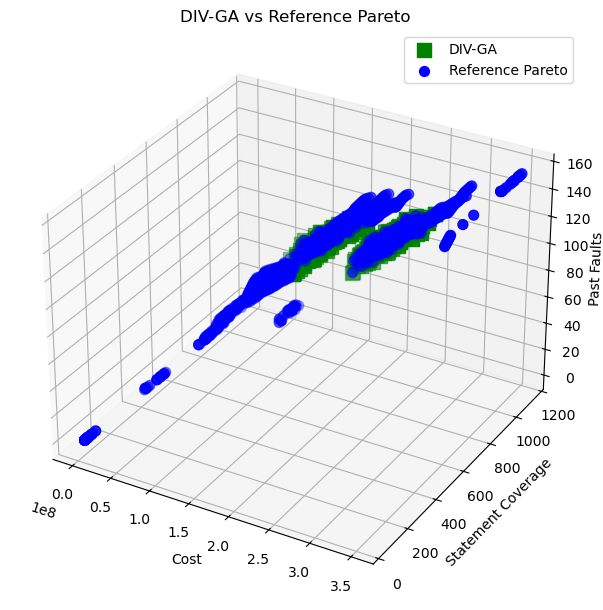

In [14]:
# Unpack the tuples for each list
def unpack_tuples(data):
    return zip(*data)

#qtcs_pareto_vectors,divga_pareto_vectors,greedy_pareto_vectors

#x1, y1, z1 = unpack_tuples(qtcs_pareto_vectors)
x2, y2, z2 = unpack_tuples(divga_pareto_vectors)
#x3, y3, z3 = unpack_tuples(greedy_pareto_vectors)
#x4, y4, z4 = unpack_tuples(qaoa_pareto_vectors)
x5, y5, z5 = unpack_tuples(reference_pareto)

# Create 3D scatter plots
fig = plt.figure(figsize=(18,6))

"""# First plot: list1 vs list5
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(x1, y1, z1, c='r', marker='s', s=100, label='QA')
ax1.scatter(x5, y5, z5, c='b', marker='o', s=50, label='Reference Pareto')
ax1.set_xlabel('Cost')
ax1.set_ylabel('Statement Coverage')
ax1.set_zlabel('Past Faults',labelpad=0.2)
ax1.set_title('QA vs Reference')
ax1.legend()"""

# Second plot: list2 vs list5
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(x2, y2, z2, c='g', marker='s', s=100, label='DIV-GA')
ax2.scatter(x5, y5, z5, c='b', marker='o', s=50, label='Reference Pareto')
ax2.set_xlabel('Cost')
ax2.set_ylabel('Statement Coverage')
ax2.set_zlabel('Past Faults',labelpad=0.2)
ax2.set_title('DIV-GA vs Reference Pareto')
ax2.legend()

"""# Third plot: list3 vs list5
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(x3, y3, z3, c='m', marker='s', s=100, label='Add. Greedy')
ax3.scatter(x5, y5, z5, c='b', marker='o', s=50, label='Reference Pareto')
ax3.set_xlabel('Cost')
ax3.set_ylabel('Statement Coverage')
ax3.set_zlabel('Past Faults',labelpad=0.2)
ax3.set_title('Add. Greedy vs Reference Pareto')
ax3.legend()

# Third plot: list4 vs list5
ax4 = fig.add_subplot(133, projection='3d')
ax4.scatter(x4, y4, z4, c='m', marker='s', s=100, label='QAOA')
ax4.scatter(x5, y5, z5, c='b', marker='o', s=50, label='Reference Pareto')
ax4.set_xlabel('Cost')
ax4.set_ylabel('Statement Coverage')
ax4.set_zlabel('Past Faults',labelpad=0.2)
ax4.set_title('QAOA vs Reference Pareto')
ax4.legend()"""

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
from scipy.interpolate import interp1d


def interpolate_curve(curve, num_points):
    """Interpolate a 3D curve to have a specified number of points."""
    curve = np.array(curve)
    t = np.linspace(0, 1, len(curve))
    interp_func = interp1d(t, curve, axis=0, kind='linear')
    t_new = np.linspace(0, 1, num_points)
    return interp_func(t_new)

def compute_area_between_curves(curve1, curve2):
    """Compute the approximate area between two 3D curves with different numbers of points."""
    # Determine the target number of points
    num_points = max(len(curve1), len(curve2))
    
    # Interpolate both curves to have the same number of points
    curve1_resampled = interpolate_curve(curve1, num_points)
    curve2_resampled = interpolate_curve(curve2, num_points)
    
    # Calculate the distance between corresponding points on the two curves
    distances = np.linalg.norm(curve1_resampled - curve2_resampled, axis=1)
    
    # Calculate the distance between consecutive points on the curves
    segment_lengths = np.linalg.norm(np.diff(curve1_resampled, axis=0), axis=1)
    
    # Compute the approximate area using the trapezoidal rule
    area = np.sum((distances[:-1] + distances[1:]) / 2 * segment_lengths)
    
    return area

area_between_curves = compute_area_between_curves(qtcs_pareto_vectors, reference_pareto)
print("Approximate area between the two curves:", area_between_curves)

In [14]:
# greedy has just one frontier
#print("Greedy Pareto Vectors: " + str(greedy_pareto_vectors))
#print("DIV-GA Pareto Vectors: " + str(divga_pareto_vectors))
#print("SelectQA Pareto Vectors: " + str(qtcs_pareto_vectors))
#total_fronts has fronts, each front has different solutions
IH_add_greedy = greedy_pareto_vectors[0][0]
for index, solution in enumerate(greedy_pareto_vectors):
    if index == len(greedy_pareto_vectors) - 2:
        break
    IH_add_greedy += (greedy_pareto_vectors[index+1][0] - greedy_pareto_vectors[index][0]) * (1 - (greedy_pareto_vectors[index][2]/len(greedy_pareto_front[index])))
IEC_add_greedy = IH_add_greedy/greedy_pareto_vectors[len(greedy_pareto_vectors)-1][0]
print("IH Additional Greedy: " + str(IH_add_greedy))
print("IEC Additional Greedy: " + str(IEC_add_greedy))

IH Additional Greedy: 219337805.6921406
IEC Additional Greedy: 0.9181388776768071


In [15]:
IECs_qtcs = []
IECs_divga = []
IECs_qaoa = []

for front_index in range(0,10):
    print("IT Number: " + str(front_index))
    IH_qtcs = 0
    IH_divga = 0
    IEC_qtcs = 0
    IEC_divga = 0
    IH_qaoa = 0
    IEC_qaoa = 0
    # Load the JSON file
    with open('./results/selectqa/grep-data.json', 'r') as file:
        pareto_fronts_json = json.load(file)
    
    qtcs_pareto_front = pareto_fronts_json['pareto_front_'+str(front_index)]
    qtcs_pareto_vectors = []
    #a single solution is a subset of the initial test suite
    for front_solution in qtcs_pareto_front:
        qtcs_pareto_vectors.append((total_cost("grep",front_solution),total_coverage("grep",front_solution),total_faults("grep",front_solution)))
    #print(len(qtcs_pareto_vectors))
    
    for index, solution in enumerate(qtcs_pareto_vectors):
        if index == len(qtcs_pareto_vectors) - 2:
            break
        IH_qtcs += (qtcs_pareto_vectors[index+1][0] - qtcs_pareto_vectors[index][0]) * (1 - (qtcs_pareto_vectors[index][2]/len(qtcs_pareto_front[index])))
    IEC_qtcs = IH_qtcs/qtcs_pareto_vectors[len(qtcs_pareto_vectors)-1][0]
    IECs_qtcs.append(IEC_qtcs)
    qtcs_pareto_vectors = sorted(qtcs_pareto_vectors, key=lambda x: x[0])
    print("IH SelectQA: " + str(IH_qtcs))
    print("IEC SelectQA: " + str(IEC_qtcs))
    
    with open('./results/divga/grep_pareto_fronts_divga.json', 'r') as file:
        pareto_fronts_json = json.load(file)
    
    divga_pareto_front = pareto_fronts_json['grep_pareto_front_'+str(front_index)]
    divga_pareto_vectors = []
    for front_solution in divga_pareto_front:
        divga_pareto_vectors.append((total_cost("grep",front_solution),total_coverage("grep",front_solution),total_faults("grep",front_solution)))
    divga_pareto_vectors = sorted(divga_pareto_vectors, key=lambda x: x[0])
    #print(len(divga_pareto_vectors))
    
    for index, solution in enumerate(divga_pareto_vectors):
        if index == len(divga_pareto_vectors) - 2:
            break
        IH_divga += (divga_pareto_vectors[index+1][0] - divga_pareto_vectors[index][0]) * (1 - (divga_pareto_vectors[index][2]/len(faults_dictionary["grep"])))
    IEC_divga = IH_divga/divga_pareto_vectors[len(divga_pareto_vectors)-1][0]
    IECs_divga.append(IEC_divga)
    print("IH DIV-GA: " + str(IH_divga))
    print("IEC DIV-GA: " + str(IEC_divga))
    
    # Load the JSON file
    with open('results/selectqaoa/statevector_sim/grep-data.json', 'r') as file:
        pareto_fronts_json = json.load(file)
    
    qaoa_pareto_front = pareto_fronts_json['pareto_front_'+str(front_index+1)]
    qaoa_pareto_vectors = []
    #a single solution is a subset of the initial test suite
    for front_solution in qaoa_pareto_front:
        qaoa_pareto_vectors.append((total_cost("grep",front_solution),total_coverage("grep",front_solution),total_faults("grep",front_solution)))
    #print(len(qaoa_pareto_vectors))
    
    for index, solution in enumerate(qaoa_pareto_vectors):
        if index == len(qaoa_pareto_vectors) - 2:
            break
        IH_qaoa += (qaoa_pareto_vectors[index+1][0] - qaoa_pareto_vectors[index][0]) * (1 - (qaoa_pareto_vectors[index][2]/len(qaoa_pareto_front[index])))
    IEC_qaoa = IH_qaoa/qaoa_pareto_vectors[len(qaoa_pareto_vectors)-1][0]
    IECs_qaoa.append(IEC_qaoa)
    qaoa_pareto_vectors = sorted(qaoa_pareto_vectors, key=lambda x: x[0])
    print("IH SelectQAOA: " + str(IH_qaoa))
    print("IEC SelectQAOA: " + str(IEC_qaoa))
    
print("Mean IECs_qtcs: " + str(statistics.mean(IECs_qtcs)))
print("Mean IECs_divga: " + str(statistics.mean(IECs_divga)))
print("Mean IECs_qaoa: " + str(statistics.mean(IECs_qaoa)))

IT Number: 0
IH SelectQA: 61972265.628443405
IEC SelectQA: 0.5145527384027266
IH DIV-GA: 45008611.55583126
IEC DIV-GA: 0.32221970533456484
IH SelectQAOA: 71946331.13769934
IEC SelectQAOA: 0.5044624106254872
IT Number: 1
IH SelectQA: 62560989.563522294
IEC SelectQA: 0.5275084924574629
IH DIV-GA: 27996296.442928042
IEC DIV-GA: 0.21950774226585873
IH SelectQAOA: 86677932.4562597
IEC SelectQAOA: 0.5407567635730499
IT Number: 2
IH SelectQA: 56449371.767490305
IEC SelectQA: 0.4839742034805403
IH DIV-GA: 39576757.80024814
IEC DIV-GA: 0.28400456508538396
IH SelectQAOA: 75622445.75482835
IEC SelectQAOA: 0.5017462703854011
IT Number: 3
IH SelectQA: 61712912.55596429
IEC SelectQA: 0.5101340277813459
IH DIV-GA: 29609819.5260546
IEC DIV-GA: 0.22978285253096645
IH SelectQAOA: 80789073.79664522
IEC SelectQAOA: 0.531952802403443
IT Number: 4
IH SelectQA: 61761110.09478848
IEC SelectQA: 0.5108051087068473
IH DIV-GA: 31007847.69727046
IEC DIV-GA: 0.23800998068124765
IH SelectQAOA: 81132867.7029027
IEC S

In [16]:
#the static values below have been manually stored after each run of the experiments

qtcs_nondom_flex = [194, 194, 193, 193, 194, 189, 194, 189, 188, 187]
div_ga_nondom_flex = [140, 140, 140, 140, 140, 140, 140, 140, 140, 140]
qaoa_nondom_flex = [425, 412, 389, 391, 412, 430, 425, 382, 393, 403]
add_greedy_nondom_flex = [205]

qtcs_nondom_grep = [258, 235, 261, 251, 260, 233, 259, 265, 261, 267]
div_ga_nondom_grep = [70, 69, 70, 70, 70, 69, 70, 70, 70, 70]
qaoa_nondom_grep = [376, 316, 370, 348, 327, 338, 350, 316, 358, 405]
add_greedy_nondom_grep = [177]

qtcs_nondom_gzip = [67, 66, 69, 31, 69, 32, 64, 33, 35, 35]
div_ga_nondom_gzip = [104, 105, 101, 105, 104, 103, 103, 105, 105, 88]
qaoa_nondom_gzip = [31, 78, 75, 68, 58, 48, 56, 45, 32, 53]
add_greedy_nondom_gzip = [71]

qtcs_nondom_sed = [104, 123, 110, 105, 110, 110, 115, 101, 107, 99]
div_ga_nondom_sed = [105, 62, 105, 105, 102, 105, 105, 97, 105, 105]
qaoa_nondom_sed = [85, 48, 171, 116, 120, 111, 138, 75, 72, 146]
add_greedy_nondom_sed = [80]

lists = [qtcs_nondom_flex,div_ga_nondom_flex,qaoa_nondom_flex,qtcs_nondom_grep,div_ga_nondom_grep,qaoa_nondom_grep,qtcs_nondom_gzip,div_ga_nondom_gzip,qaoa_nondom_gzip,qtcs_nondom_sed,div_ga_nondom_sed,qaoa_nondom_sed]

# we are interested in knowing if the obtained sequences are normally distributed to decide what statistical test we should apply
for i, list in enumerate(lists, start=1):
    stat, p_value = shapiro(list)
    print(f"List {i}: Statistic = {stat:.5f}, P-value = {p_value:.5f}")
    
    # check if the sequence is normally distributed (using 0.05 as threshold)
    if p_value > 0.05:
        print(f"List {i} seems to be normally distributed (p-value = {p_value:.5f})")
    else:
        print(f"List {i} NOT seems to be normally distributed (p-value = {p_value:.5f})")

List 1: Statistic = 0.79079, P-value = 0.01120
List 1 NOT seems to be normally distributed (p-value = 0.01120)
List 2: Statistic = 1.00000, P-value = 1.00000
List 2 seems to be normally distributed (p-value = 1.00000)
List 3: Statistic = 0.92383, P-value = 0.39002
List 3 seems to be normally distributed (p-value = 0.39002)
List 4: Statistic = 0.80518, P-value = 0.01676
List 4 NOT seems to be normally distributed (p-value = 0.01676)
List 5: Statistic = 0.50927, P-value = 0.00000
List 5 NOT seems to be normally distributed (p-value = 0.00000)
List 6: Statistic = 0.95280, P-value = 0.70167
List 6 seems to be normally distributed (p-value = 0.70167)
List 7: Statistic = 0.74031, P-value = 0.00272
List 7 NOT seems to be normally distributed (p-value = 0.00272)
List 8: Statistic = 0.56962, P-value = 0.00002
List 8 NOT seems to be normally distributed (p-value = 0.00002)
List 9: Statistic = 0.95059, P-value = 0.67547
List 9 seems to be normally distributed (p-value = 0.67547)
List 10: Statisti

/opt/anaconda3/envs/SelectQAOA/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [26]:
def a12(lst1,lst2,rev=True):
  "how often is x in lst1 more than y in lst2?"
  more = same = 0.0
  for x in lst1:
    for y in lst2:
      if x==y : same += 1
      elif rev and x > y : more += 1
      elif not rev and x < y : more += 1
  return (more + 0.5*same)  / (len(lst1)*len(lst2))

def stat_test(app1, app2):
    statistic, pvalue = mannwhitneyu(app1, app2, alternative='two-sided')

    # Calculate the A12 effect size using Vargha and Delaney's formula
    a12_effect_size = a12(app1, app2)

    return pvalue, a12_effect_size

p_value, a_12 = stat_test(qaoa_nondom_sed,add_greedy_nondom_sed)
print("p_value: " + str(p_value))
print("a12: " + str(a_12))
#5.8493119157503726e-05

p_value: 0.7272727272727273
a12: 0.7


In [32]:
with open('./results/add-greedy/sed_data.json', 'r') as file:
    pareto_fronts_json = json.load(file)

greedy_execution_time = pareto_fronts_json['resolution_time(ms)']
print(greedy_execution_time)

with open('./results/selectqa/sed-data.json', 'r') as file:
    pareto_fronts_json = json.load(file)

qtcs_qpu_execution_time = pareto_fronts_json['mean_qpu_run_time(ms)']
qtcs_pareto_building_time = pareto_fronts_json['mean_pareto_fronts_building_time(ms)']
print(qtcs_qpu_execution_time)
print(qtcs_pareto_building_time)

with open('./results/divga/sed_pareto_fronts_divga.json', 'r') as file:
    pareto_fronts_json = json.load(file)

divga_execution_time = pareto_fronts_json['DIVGA_II_mean_execution_time_ms']
print(divga_execution_time)

with open('results/selectqaoa/statevector_sim/sed-data.json', 'r') as file:
    pareto_fronts_json = json.load(file)

qaoa_qpu_execution_time = pareto_fronts_json['mean_qpu_run_time(ms)']
qaoa_pareto_building_time = pareto_fronts_json['mean_pareto_fronts_building_time(ms)']
print(qaoa_qpu_execution_time)
print(qaoa_pareto_building_time)

4151.939868927002
2992330.4
158886.62610054016
142850.35602
7390.933908224106
132122.140955925


## BootQA

BootQA is the first approach to a test case optimization problem using quantum computing. BootQA relies on real-world industrial datasets:

- PaintControl: dataset gathered from ABB Robotics Norway;
- GSDTSR: dataset gathered from Google.

 Each test case in both the datasets has values related to the properties:
 
- "execution time": time needed by the test case to be executed;
- "failure rate": the ability, in percentage, of a test case to spot a failure.

To deal with physical limitations of quantum annealers, BootQA randomly divides the problem into m sub-problems of size n; once it has obtained the m sub-solutions, BootQA merges them into one final solution.

## Evaluation Metrics

To compare SelectQA and BootQA were executed 10 indipendent experiments for each dataset. The resulting suites (10 for each dataset) were directly confronted in terms of "execution time" and "failure rate". The statistical tests used the same methods used for the previous comparisons.

To compare the efficiency of the two methods, has been use the "QPU Access Time" metric.

In [3]:
def bootstrap_confidence_interval(data, num_samples, confidence_alpha=0.95):
    """This function determines the statistical range within we would expect the mean value of execution times to fall; it relies on the bootstrapping strategy, which allows the calculation of the confidence interval by repeated sampling (with replacement) from the existing data to obtain an estimate of the confidence interval."""
    sample_means = []
    for _ in range(num_samples):
        bootstrap_sample = [random.choice(data) for _ in range(len(data))]
        sample_mean = np.mean(bootstrap_sample)
        sample_means.append(sample_mean)
    
    lower_percentile = (1 - confidence_alpha) / 2 * 100
    upper_percentile = (confidence_alpha + (1 - confidence_alpha) / 2) * 100
    lower_bound = np.percentile(sample_means, lower_percentile)
    upper_bound = np.percentile(sample_means, upper_percentile)
    
    return lower_bound, upper_bound

In [4]:
def make_linear_terms_bootqa(cluster_test_cases, test_cases_costs, test_cases_rates, alpha):
    max_cost = max(test_cases_costs)
    
    estimated_costs = []

    #linear coefficients, that are the diagonal of the matrix encoding the QUBO
    for test_case in cluster_test_cases:
        estimated_costs.append((alpha * ((test_cases_costs[test_case])/max_cost)) - ((1-alpha)*test_cases_rates[test_case]))
    
    return np.array(estimated_costs)

In [5]:
def create_linear_qubo(linear_terms):
    """This function is the one that has to encode the QUBO problem that QAOA will have to solve. The QUBO problem specifies the optimization to solve and a quadratic binary unconstrained problem"""
    qubo = QuadraticProgram()
    
    for i in range(0,len(linear_terms)):
        qubo.binary_var('x%s' % (i))

    qubo.minimize(linear=linear_terms)

    return qubo

Tot suite cost: 48374589.23585534
Tot suite rate: 8.743228702983895
Cluster 6 metrics:
Test Cases: [6]
 - Num. Test Cases: 1.00
 - Execution Cost: 92685.55
 - Failure Rate: 0.3805584281282316
Cluster 23 metrics:
Test Cases: [8, 104, 139, 247, 271]
 - Num. Test Cases: 5.00
 - Execution Cost: 288771.38
 - Failure Rate: 0.08763195412764099
Cluster 38 metrics:
Test Cases: [9, 13, 32, 38, 40, 83, 127, 180, 203, 265]
 - Num. Test Cases: 10.00
 - Execution Cost: 2618852.69
 - Failure Rate: 0.07877592620595861
Cluster 32 metrics:
Test Cases: [10, 41, 205, 206, 233]
 - Num. Test Cases: 5.00
 - Execution Cost: 2875689.90
 - Failure Rate: 0.0372600840243577
Cluster 40 metrics:
Test Cases: [11, 34, 136, 144, 207, 235, 268, 272]
 - Num. Test Cases: 8.00
 - Execution Cost: 2989328.12
 - Failure Rate: 0.058049124770089
Cluster 31 metrics:
Test Cases: [14, 30, 188]
 - Num. Test Cases: 3.00
 - Execution Cost: 1947949.69
 - Failure Rate: 0.0380740539258088
Cluster 13 metrics:
Test Cases: [19, 26]
 - Num

/var/folders/kn/kd67nwcs41113fgwjn39d7fm0000gn/T/ipykernel_1182/2375833913.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(clustered_data))  # A colormap with as many colors as clusters


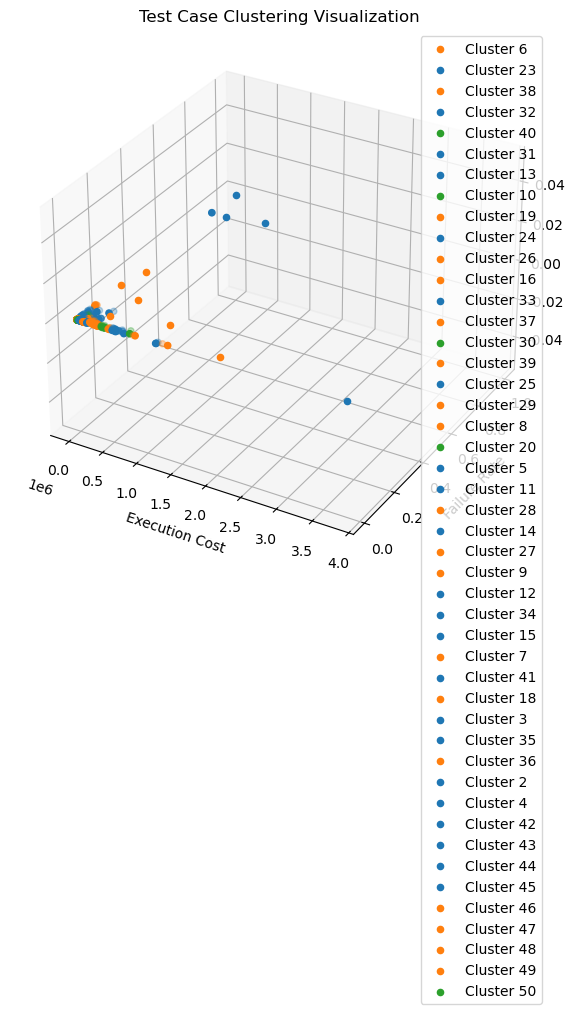

Tot suite cost: 3005225.0
Tot suite rate: 20.317411495740192
Cluster 8 metrics:
Test Cases: [0, 36, 38, 40, 48, 51, 52, 53, 56, 57]
 - Num. Test Cases: 10.00
 - Execution Cost: 361976.00
 - Failure Rate: 1.5242816742894516
Cluster 2 metrics:
Test Cases: [1, 37, 39, 42, 43, 44, 46, 49, 50]
 - Num. Test Cases: 9.00
 - Execution Cost: 65463.00
 - Failure Rate: 1.2741313284593103
Cluster 6 metrics:
Test Cases: [2, 3]
 - Num. Test Cases: 2.00
 - Execution Cost: 86188.00
 - Failure Rate: 0.16929144566843451
Cluster 12 metrics:
Test Cases: [4, 6, 7, 9, 14, 16, 17, 21, 22, 55, 83, 87]
 - Num. Test Cases: 12.00
 - Execution Cost: 537384.00
 - Failure Rate: 2.30497479546655
Cluster 4 metrics:
Test Cases: [5, 8, 10, 13, 15, 18, 20, 23, 45, 58, 60]
 - Num. Test Cases: 11.00
 - Execution Cost: 183314.00
 - Failure Rate: 2.0375716461812288
Cluster 9 metrics:
Test Cases: [11, 78]
 - Num. Test Cases: 2.00
 - Execution Cost: 18731.00
 - Failure Rate: 0.6178155243926526
Cluster 14 metrics:
Test Cases: [

/var/folders/kn/kd67nwcs41113fgwjn39d7fm0000gn/T/ipykernel_1182/2375833913.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(clustered_data))  # A colormap with as many colors as clusters


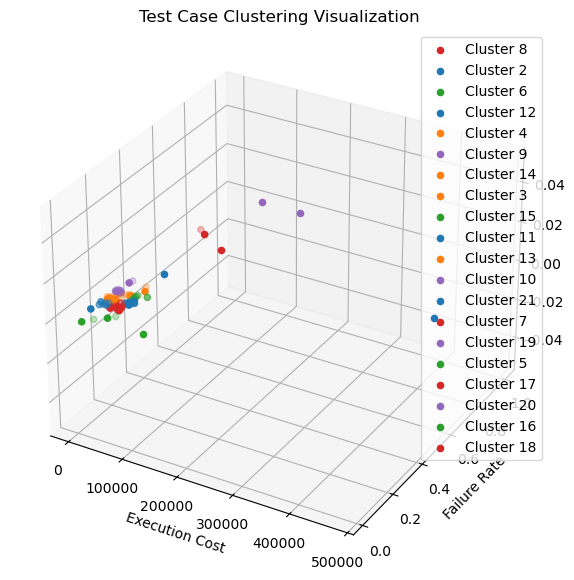

In [20]:



def get_data(data_name):
    data = pd.read_csv("datasets/boot_qa_datasets/" + data_name + ".csv", dtype={"time": float, "rate": float})
    data = data[data['rate'] > 0]
    return data

bootqa_programs = ["gsdtsr","paintcontrol"]
bootqa_clusters = dict()

for bootqa_program in bootqa_programs:
    data = get_data(bootqa_program)
    
    # Total suite metrics
    test_cases_costs = data["time"].tolist()
    test_cases_rates = data["rate"].tolist()
    print(f"Tot suite cost: {sum(test_cases_costs)}")
    print(f"Tot suite rate: {sum(test_cases_rates)}")
        
    # Normalize data
    cluster_data = np.column_stack((test_cases_costs, test_cases_rates))
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(cluster_data)
    
    if bootqa_program == "gsdtsr":
        num_clusters = 40
    else:
        num_clusters = 20
    
    linkage_matrix = linkage(normalized_data, method='ward')
    clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')
    
    # Organize test cases by cluster and split large clusters
    clustered_data = defaultdict(list)
    for idx, cluster_id in enumerate(clusters):
        clustered_data[cluster_id].append(idx)
        
    # Process clusters to split large ones into 3 parts if they exceed 30 elements
    new_cluster_id = max(clustered_data.keys()) + 1  # Start new IDs after existing ones
    to_add = []  # To collect new smaller clusters for adding
    
    for cluster_id, elements in list(clustered_data.items()):  # Use list() to avoid modifying during iteration
        if len(elements) > 30:
            # Split into 3 parts
            split_size = max(1, len(elements) // 3)  # Calculate split size, ensuring minimum size of 1
            parts = [elements[i:i + split_size] for i in range(0, len(elements), split_size)]
    
            # Ensure we end up with exactly 3 parts
            while len(parts) < 3:
                parts.append([])  # Add empty parts if fewer than 3
    
            # Add new parts to to_add list
            to_add.extend(parts[:3])
    
            # Remove original large cluster
            del clustered_data[cluster_id]
    
    # Add new clusters to clustered_data with new IDs
    for part in to_add:
        if part:  # Only add if the part is non-empty
            clustered_data[new_cluster_id] = part
            new_cluster_id += 1
    
    bootqa_clusters[bootqa_program] = clustered_data
    
    # Step 3: Calculate the metrics for each refined cluster
    cluster_metrics = {}
    for cluster_id, members in clustered_data.items():
        tot_cluster_costs = sum(test_cases_costs[i] for i in members)
        tot_cluster_rates = sum(test_cases_rates[i] for i in members)
        cluster_metrics[cluster_id] = {
            "tot_cluster_cost": tot_cluster_costs,
            "tot_cluster_rates": tot_cluster_rates
        }
        print(f"Cluster {cluster_id + 1} metrics:")
        print(f"Test Cases: {members}")
        print(f" - Num. Test Cases: {len(members):.2f}")
        print(f" - Execution Cost: {tot_cluster_costs:.2f}")
        print(f" - Failure Rate: {tot_cluster_rates}")
        
    for cluster_id in clustered_data.keys():
        print("Program: " + bootqa_program)
        print("Test cases of cluster " + str(cluster_id) + ": " + str(len(clustered_data[cluster_id])))
    
    # Plotting the clusters in 3D space
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extracting data for plotting
    exec_costs = np.array(test_cases_costs)
    rates = np.array(test_cases_rates)
    
    # Plot each refined cluster with a different color
    colors = plt.cm.get_cmap("tab10", len(clustered_data))  # A colormap with as many colors as clusters
    for cluster_id, members in clustered_data.items():
        ax.scatter(
            exec_costs[members], 
            rates[members], 
            color=colors(cluster_id % 10), 
            label=f"Cluster {cluster_id + 1}"
        )
    
    # Label the axes
    ax.set_xlabel("Execution Cost")
    ax.set_ylabel("Failure Rate")
    ax.legend()
    ax.set_title("Test Case Clustering Visualization")
    
    # Display the plot
    plt.show()


In [22]:


bootqa_alphas = {"gsdtsr": 0.98,"paintcontrol": 0.90}
run_times_dictionary = {"gsdtsr": [],"paintcontrol": []}

algorithm_globals.random_seed = 10598
backend = Aer.get_backend("statevector_simulator")
qaoa_mes = QAOA(sampler=BackendSampler(backend=backend), optimizer=COBYLA(), reps=1)
qaoa = MinimumEigenOptimizer(qaoa_mes)

for bootqa_program in bootqa_programs:
    data = get_data(bootqa_program)
    # Total suite metrics
    test_cases_costs = data["time"].tolist()
    test_cases_rates = data["rate"].tolist()
    
    final_test_suite_costs = []
    final_failure_rates = []
    for i in range(tot_run):
        final_selected_cases = []
        cluster_number = 0
        for cluster_id in bootqa_clusters[bootqa_program]:
            print("Cluster: " + str(bootqa_clusters[bootqa_program][cluster_id]))
            linear_terms = make_linear_terms_bootqa(bootqa_clusters[bootqa_program][cluster_id], test_cases_costs, test_cases_rates, bootqa_alphas[bootqa_program])
            linear_qubo = create_linear_qubo(linear_terms)
            print("Linear QUBO: " + str(linear_qubo))
            #for each iteration get the result
            s = time.time()
            qaoa_result = qaoa.solve(linear_qubo)
            print("QAOA Result: " + str(qaoa_result))
            e = time.time()
            run_times_dictionary[bootqa_program].append((e-s)*1000)
            
            variable_values = qaoa_result.x
            indexes_selected_cases = [index for index, value in enumerate(variable_values) if value == 1]
            print("Indexes of selected tests to convert. " + str(indexes_selected_cases))
            selected_tests = []
            for index in indexes_selected_cases:
                selected_tests.append(bootqa_clusters[bootqa_program][cluster_id][index])
            print("Selected tests: " + str(selected_tests))
            for selected_test in selected_tests:
                if selected_test not in final_test_suite_costs:
                    final_selected_cases.append(selected_test)
            
        #compute the final test suite cost
        final_test_suite_cost = 0
        for selected_test_case in final_selected_cases:
            final_test_suite_cost += test_cases_costs[selected_test_case]
        final_test_suite_costs.append(final_test_suite_cost)
            
        #compute the total failure rate
        final_failure_rate = 0
        for selected_test_case in final_selected_cases:
            final_failure_rate += test_cases_rates[selected_test_case]
        final_failure_rates.append(final_failure_rate)
    
    print("Final Test Suite: " + str(final_selected_cases))
    #compute the qpu access times
    qpu_run_times_without_zeros = []
    for access_time in run_times_dictionary[bootqa_program]:
      if access_time != 0:
        qpu_run_times_without_zeros.append(access_time)
    lower_bound, upper_bound = bootstrap_confidence_interval(qpu_run_times_without_zeros, 1000, 0.95)
    for i in range(len(run_times_dictionary[bootqa_program])):
      if run_times_dictionary[bootqa_program][i] == 0:
          run_times_dictionary[bootqa_program][i] = upper_bound
    average_qpu_access_time = statistics.mean(run_times_dictionary[bootqa_program]) 
    
    var_names = ["final_test_suite_costs", "final_failure_rates",
                 "average_qpu_access_time(ms)", "qpu_lower_bound(ms)", "qpu_upper_bound()"]
    values = [final_test_suite_costs, final_failure_rates, average_qpu_access_time, lower_bound, upper_bound]
    
    # Ensure the directory exists
    output_dir = "results/selectqaoa/"
    os.makedirs(output_dir, exist_ok=True)
    
    # Path to save the file
    file_path = os.path.join(output_dir, f"{bootqa_program}.csv")
    
    # Writing results to the file
    with open(file_path, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(var_names)
        writer.writerow(values)
    print(f"Results saved to {file_path}")

/var/folders/kn/kd67nwcs41113fgwjn39d7fm0000gn/T/ipykernel_1182/3664298728.py:8: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  qaoa_mes = QAOA(sampler=BackendSampler(backend=backend), optimizer=COBYLA(), reps=1)


Cluster: [6]
Linear QUBO: minimize 0.01636819998765336*x0 (1 variables, 0 constraints, '')
QAOA Result: fval=0.0, x0=0.0, status=SUCCESS
Indexes of selected tests to convert. []
Selected tests: []
Cluster: [8, 104, 139, 247, 271]
Linear QUBO: minimize 0.013670309770142886*x0 + 0.01710983873502796*x1 + 0.009087021234012668*x2 + 0.015155377530859757*x3 + 0.017935006788802298*x4 (5 variables, 0 constraints, '')
QAOA Result: fval=0.05584771532381761, x0=1.0, x1=0.0, x2=1.0, x3=1.0, x4=1.0, status=SUCCESS
Indexes of selected tests to convert. [0, 2, 3, 4]
Selected tests: [8, 139, 247, 271]
Cluster: [9, 13, 32, 38, 40, 83, 127, 180, 203, 265]
Linear QUBO: minimize 0.07167439033460118*x0 + 0.06171946661053965*x1 + 0.07141840423732217*x2 + 0.06186651623470079*x3 + 0.06632647152447625*x4 + 0.07103981464417632*x5 + 0.07265618069332878*x6 + 0.06798074649369876*x7 + 0.06670751070778098*x8 + 0.06457784323810471*x9 (10 variables, 0 constraints, '')
QAOA Result: fval=0.4115221233868466, x0=0.0, x1=1.